In [1]:
# -*- coding: utf-8 -*-
"""
Created on Fri Oct  4 14:33:21 2019

@author: Theo
"""


import numpy as np
import openpiv.windef as windef
from openpiv.test import test_process 
from openpiv import preprocess
import pathlib
import os
import matplotlib.pyplot as plt

frame_a, frame_b = test_process.create_pair(image_size=256)
shift_u, shift_v, threshold = test_process.shift_u, test_process.shift_v, \
                              test_process.threshold

# this test are created only to test the displacement evaluation of the
# function the validation methods are not tested here ant therefore
# are disabled.

settings = windef.Settings()
settings.windowsizes = (64,)
settings.overlap = (32,)
settings.num_iterations = 1
settings.correlation_method = 'circular'
settings.sig2noise_method = 'peak2peak'
settings.subpixel_method = 'gaussian'
settings.sig2noise_mask = 2
settings.sig2noise_validate = True


# circular cross correlation
def test_first_pass_circ():
    """ test of the first pass """
    x, y, u, v, s2n = windef.first_pass(
        frame_a,
        frame_b,
        settings
    )
    print("\n", x, y, u, v, s2n)
    assert np.mean(np.abs(u - shift_u)) < threshold
    assert np.mean(np.abs(v - shift_v)) < threshold


def test_multi_pass_circ():
    """ test fot the multipass """
    settings.windowsizes = (64, 64, 16)
    settings.overlap = (32, 32, 8)
    settings.num_iterations = 2
    settings.interpolation_order = 3
    settings.show_all_plots = True

    x, y, u, v, s2n = windef.first_pass(
        frame_a,
        frame_b,
        settings,
    )
    
    plt.figure()
    plt.quiver(x,y,u,v)
    plt.show()
    
    print("first pass\n")
    print("\n", x, y, u, v, s2n)
    assert np.allclose(u, shift_u, atol = threshold)
    assert np.allclose(v, shift_v, atol = threshold)

    if settings.image_mask:
        image_mask = np.logical_and(mask_a, mask_b)
        mask_coords = preprocess.mask_coordinates(image_mask)
        # mark those points on the grid of PIV inside the mask
        grid_mask = preprocess.prepare_mask_on_grid(x,y,mask_coords)

        # mask the velocity
        u = np.ma.masked_array(u, mask=grid_mask)
        v = np.ma.masked_array(v, mask=grid_mask)
    else:
        mask_coords = []
        u = np.ma.masked_array(u, mask=np.ma.nomask)
        v = np.ma.masked_array(v, mask=np.ma.nomask)

    for i in range(1,settings.num_iterations):
        x, y, u, v, s2n, _ = windef.multipass_img_deform(
            frame_a,
            frame_b,
            i,
            x,
            y,
            u,
            v,
            settings
        )

    print(f"Pass {i}\n")
    print(x)
    print(y)
    print(u) 
    print(v)
    print(s2n)
    assert np.mean(np.abs(u - shift_u)) < threshold
    assert np.mean(np.abs(v - shift_v)) < threshold
    # the second condition is to check if the multipass is done.
    # It need's a little numerical inaccuracy.


# linear cross correlation
def test_first_pass_lin():
    """ test of the first pass """
    settings.correlation_method = 'linear'

    x, y, u, v, s2n = windef.first_pass(
        frame_a,
        frame_b,
        settings,
    )
    print("\n", x, y, u, v, s2n)
    assert np.mean(np.abs(u - shift_u)) < threshold
    assert np.mean(np.abs(v - shift_v)) < threshold


def test_invert():
    """ Test windef.piv with invert option """

    settings = windef.Settings()
    'Data related settings'
    # Folder with the images to process
    settings.filepath_images = pathlib.Path(__file__).parent / '../examples/test1'
    settings.save_path = '.'
    # Root name of the output Folder for Result Files
    settings.save_folder_suffix = 'test'
    # Format and Image Sequence
    settings.frame_pattern_a = 'exp1_001_a.bmp'
    settings.frame_pattern_b = 'exp1_001_b.bmp'

    settings.num_iterations = 1
    settings.show_plot = True
    settings.scale_plot = 100
    settings.show_all_plots = False
    settings.invert = True

    windef.piv(settings)


def test_multi_pass_lin():
    """ test fot the multipass """
    settings.windowsizes = (64, 32, 16)
    settings.overlap = (32, 16, 8)
    settings.num_iterations = 2
    settings.sig2noise_validate = True
    settings.correlation_method = 'linear'
    settings.normalized_correlation = True

    x, y, u, v, s2n = windef.first_pass(
        frame_a,
        frame_b,
        settings,
    )

    print("\n", x, y, u, v, s2n)
    assert np.mean(np.abs(u - shift_u)) < threshold
    assert np.mean(np.abs(v - shift_v)) < threshold

    if settings.image_mask:
        image_mask = np.logical_and(mask_a, mask_b)
        mask_coords = preprocess.mask_coordinates(image_mask)
        # mark those points on the grid of PIV inside the mask
        grid_mask = preprocess.prepare_mask_on_grid(x,y,mask_coords)

        # mask the velocity
        u = np.ma.masked_array(u, mask=grid_mask)
        v = np.ma.masked_array(v, mask=grid_mask)
    else:
        mask_coords = []
        u = np.ma.masked_array(u, mask=np.ma.nomask)
        v = np.ma.masked_array(v, mask=np.ma.nomask)

    for i in range(1, settings.num_iterations):
        x, y, u, v, s2n, _ = windef.multipass_img_deform(
            frame_a,
            frame_b,
            i,
            x,
            y,
            u,
            v,
            settings,
        )
        print(f"Iteration {i}")
        print("\n", x, y, u, v, s2n)
        assert np.allclose(u, shift_u, atol=threshold)
        assert np.allclose(v, shift_v, atol=threshold)

    # the second condition is to check if the multipass is done.
    # It need's a little numerical inaccuracy.


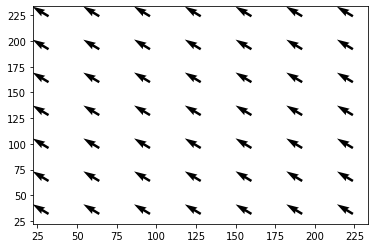

first pass


 [[ 32.  64.  96. 128. 160. 192. 224.]
 [ 32.  64.  96. 128. 160. 192. 224.]
 [ 32.  64.  96. 128. 160. 192. 224.]
 [ 32.  64.  96. 128. 160. 192. 224.]
 [ 32.  64.  96. 128. 160. 192. 224.]
 [ 32.  64.  96. 128. 160. 192. 224.]
 [ 32.  64.  96. 128. 160. 192. 224.]] [[ 32.  32.  32.  32.  32.  32.  32.]
 [ 64.  64.  64.  64.  64.  64.  64.]
 [ 96.  96.  96.  96.  96.  96.  96.]
 [128. 128. 128. 128. 128. 128. 128.]
 [160. 160. 160. 160. 160. 160. 160.]
 [192. 192. 192. 192. 192. 192. 192.]
 [224. 224. 224. 224. 224. 224. 224.]] [[-3.49333253 -3.49650393 -3.49777091 -3.48132434 -3.46997988 -3.48944437
  -3.50137951]
 [-3.49749581 -3.49405326 -3.48482151 -3.49174922 -3.49516286 -3.49081244
  -3.48369634]
 [-3.47894722 -3.48368382 -3.48735443 -3.49769104 -3.5000053  -3.49027312
  -3.48713382]
 [-3.4816461  -3.48760602 -3.49124227 -3.49710668 -3.48528828 -3.48535417
  -3.49388415]
 [-3.49094819 -3.50632911 -3.49576911 -3.48799002 -3.49408936 -3.48891076
  -3.49929285]
 [-3.50

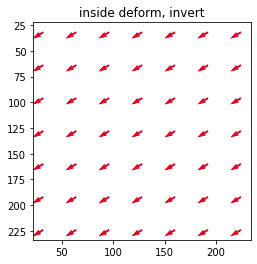

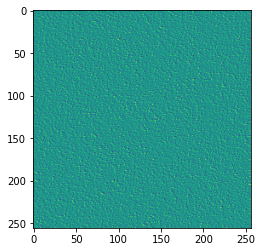

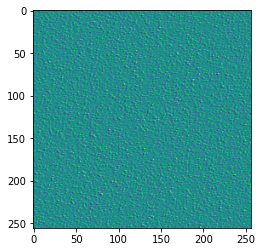

global filter invalidated 0.0 vectors
median filter invalidated 0 vectors
s2n filter invalidated 0.0 vectors


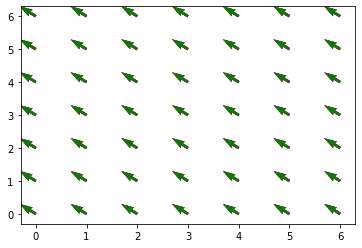

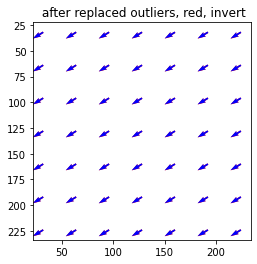

Pass 1

[[ 32.  64.  96. 128. 160. 192. 224.]
 [ 32.  64.  96. 128. 160. 192. 224.]
 [ 32.  64.  96. 128. 160. 192. 224.]
 [ 32.  64.  96. 128. 160. 192. 224.]
 [ 32.  64.  96. 128. 160. 192. 224.]
 [ 32.  64.  96. 128. 160. 192. 224.]
 [ 32.  64.  96. 128. 160. 192. 224.]]
[[ 32.  32.  32.  32.  32.  32.  32.]
 [ 64.  64.  64.  64.  64.  64.  64.]
 [ 96.  96.  96.  96.  96.  96.  96.]
 [128. 128. 128. 128. 128. 128. 128.]
 [160. 160. 160. 160. 160. 160. 160.]
 [192. 192. 192. 192. 192. 192. 192.]
 [224. 224. 224. 224. 224. 224. 224.]]
[[-3.46389692 -3.46823076 -3.4699644  -3.45295587 -3.44196894 -3.46575067
  -3.47383584]
 [-3.47092973 -3.46870161 -3.46157444 -3.46583282 -3.46616801 -3.4617865
  -3.46108624]
 [-3.46193902 -3.4583275  -3.46400861 -3.46889526 -3.46866308 -3.46195816
  -3.46412428]
 [-3.46692631 -3.4585103  -3.46354893 -3.4682335  -3.45762523 -3.45970804
  -3.46656784]
 [-3.46638477 -3.47261602 -3.46335059 -3.45977202 -3.46730173 -3.46187487
  -3.46866118]
 [-3.47593254 

In [2]:
test_multi_pass_circ()